# HW1. Autoregressive models

## Task 1. Warmup

In [31]:
import torch
import torch.nn
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
import math

def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))
data = sample_data()

In [32]:
# split 70:10:20
train_data = data[:int(0.7 * len(data))] 
val_data = data[int(0.7 * len(data)) : int(0.8 * len(data))]
test_data = data[int(0.8 * len(data)):]

In [33]:
def compute_loss(theta_vec, data_batch):
    theta_vec_exp = torch.exp(theta_vec) / torch.sum(torch.exp(theta_vec))
    probs = torch.gather(theta_vec_exp, dim=0, index=data_batch)
    loss = torch.sum(torch.log2(probs) * -1) / probs.shape[0]
    return loss

In [34]:
NUM_EPOCHS = 200
BATCH_SIZE = 1024

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)


In [35]:
theta_vec = torch.zeros(100, requires_grad=True)

optimizer = torch.optim.Adam([theta_vec], lr=0.001)

In [36]:
global_step = 0
train_losses = {}
val_losses = {}

for epoch in range(NUM_EPOCHS):
    for idx, train_batch in enumerate(train_loader):
        loss = compute_loss(theta_vec, train_batch)
        loss.backward()

        optimizer.step()

        train_losses[global_step] = loss.item()
        global_step += 1

        print('\rINFO: [Epoch %d/%d][idx %d/%d][Global Step: %d] Loss: %s'\
            % (epoch, NUM_EPOCHS, idx, len(train_loader), global_step, loss.item()), end="")

    for idx, val_batch in enumerate(val_loader):
        val_loss = compute_loss(theta_vec, val_batch)

    val_losses[global_step] = val_loss.item()


INFO: [Epoch 199/200][idx 6/7][Global Step: 1400] Loss: 5.8485641479492195

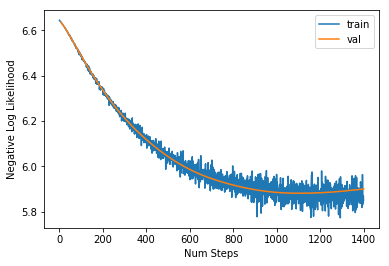

In [37]:
val_x_vals = val_losses.keys()
val_y_vals = val_losses.values()

# Plot the graphs
plt.xlabel('Num Steps')
plt.ylabel('Negative Log Likelihood')
train_x_vals = sorted(train_losses.keys())
train_y_vals = [train_losses[k] for k in train_x_vals]
val_x_vals = sorted(val_losses.keys())
val_y_vals = [val_losses[k] for k in val_x_vals]

plt.plot(train_x_vals, train_y_vals, label='train')
plt.plot(val_x_vals, val_y_vals, label='val')

plt.legend(loc='best')
plt.show()

In [38]:
for idx, test_batch in enumerate(test_loader):
    test_loss = compute_loss(theta_vec, test_batch)

In [39]:
print("Final Training Loss:", train_y_vals[-1])
print("Final Validation Loss:", val_y_vals[-1])
print("Final Test Loss:", test_loss.item())

Final Training Loss: 5.848564147949219
Final Validation Loss: 5.899538040161133
Final Test Loss: 5.890964984893799


In [40]:
theta_vec_exp = torch.exp(theta_vec) / torch.sum(torch.exp(theta_vec))
theta_vec_exp = theta_vec_exp.detach().numpy()

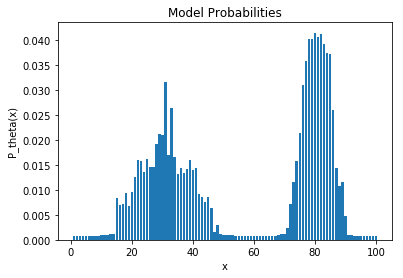

In [41]:
plt.bar(range(1, 101), theta_vec_exp)
plt.title("Model Probabilities")
plt.xlabel("x")
plt.ylabel("P_theta(x)")
plt.show()

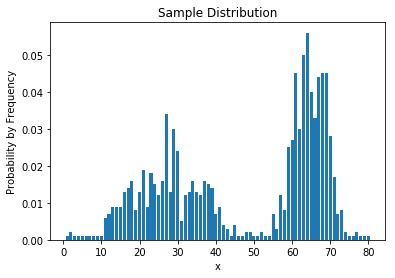

In [42]:
from torch.distributions import Categorical
from collections import Counter

m = Categorical(torch.exp(theta_vec) / torch.sum(torch.exp(theta_vec)))
action = m.sample_n(1000).detach().numpy()
counts = Counter(action)
freq_probs = [counts[k] / len(action) for k in sorted(counts.keys())]

plt.title("Sample Distribution")
plt.xlabel("x")
plt.ylabel("Probability by Frequency")
plt.bar(range(1, len(freq_probs)+1), freq_probs)
plt.show()

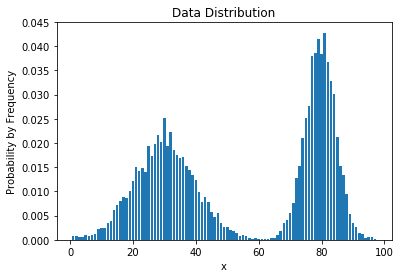

In [43]:


counts = Counter(data)
freq_probs = [counts[k] / len(data) for k in sorted(counts.keys())]

plt.title("Data Distribution")
plt.xlabel("x")
plt.ylabel("Probability by Frequency")
plt.bar(range(1, len(freq_probs)+1), freq_probs)
plt.show()

## Task 2. Two-dimensional data
### Part 1. Model with MLP.

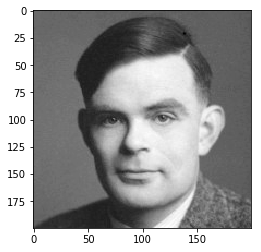

In [44]:
distribution = np.load('distribution.npy')
plt.imshow(distribution, cmap='gray')

In [45]:
m = Categorical(torch.from_numpy(distribution.flatten()))
data = m.sample_n(100000).detach().numpy()

In [46]:
data = np.array([[x // 200, x % 200] for x in data])

In [47]:
# split 70:10:20
train_data = data[:int(0.7 * len(data))] 
val_data = data[int(0.7 * len(data)) : int(0.8 * len(data))]
test_data = data[int(0.8 * len(data)):]

In [48]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False)


In [49]:
import torch.nn.functional as F
class ModelSimple(torch.nn.Module):
    def __init__(self):
        super(ModelSimple, self).__init__()
        self.theta_vec = torch.zeros(200, requires_grad=True)
        self.fc1 = torch.nn.Linear(200, 400)
        self.fc2 = torch.nn.Linear(400, 200)
    def forward(self, x):
        p1 = torch.gather(F.softmax(theta_vec), dim=0, index=x[:, 0])
        one_x = F.one_hot(x[:, 0], 200).float()
        one_x = F.relu(self.fc1(one_x))
        one_x = self.fc2(one_x)
        one_x = F.softmax(one_x)
        prob = torch.zeros(list(x.size())[0])
        for i, py in enumerate(one_x):
            prob[i] = p1[x[i][0]] * py[x[i][1]]
        loss = torch.sum(torch.log2(prob) * -1) / prob.shape[0]
        return prob, loss

In [50]:
model = ModelSimple()
theta_vec = torch.zeros(200, requires_grad=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
global_step = 0
train_losses = {}
val_losses = {}
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    for idx, train_batch in enumerate(train_loader):
        result, loss = model(train_batch)
        
        loss.backward()

        optimizer.step()

        train_losses[global_step] = loss.item()
        global_step += 1

        print('\rINFO: [Epoch %d/%d][idx %d/%d][Global Step: %d] Loss: %s'\
            % (epoch, NUM_EPOCHS, idx, len(train_loader), global_step, loss.item()), end="")

    model.eval()
    for idx, val_batch in enumerate(val_loader):
        _, val_loss = model(val_batch)
    model.train()    

    val_losses[global_step] = val_loss.item()

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


INFO: [Epoch 9/10][idx 68/69][Global Step: 690] Loss: 15.045594215393066

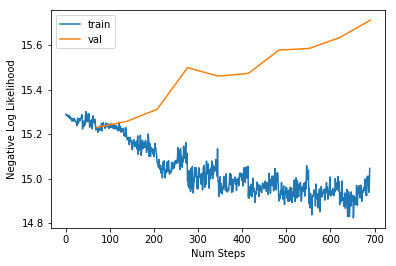

In [52]:
val_x_vals = val_losses.keys()
val_y_vals = val_losses.values()

# Plot the graphs
plt.xlabel('Num Steps')
plt.ylabel('Negative Log Likelihood')
train_x_vals = sorted(train_losses.keys())
train_y_vals = [train_losses[k] for k in train_x_vals]
val_x_vals = sorted(val_losses.keys())
val_y_vals = [val_losses[k] for k in val_x_vals]

plt.plot(train_x_vals, train_y_vals, label='train')
plt.plot(val_x_vals, val_y_vals, label='val')

plt.legend(loc='best')
plt.show()

In [53]:
arr = np.zeros(shape=(200*200, 2), dtype=int)
for i in range(200):
    for j in range(200):
        arr[i * 200 + j][0] = i
        arr[i * 200 + j][1] = j
        
new_distribution, _ = model(torch.from_numpy(arr))

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [54]:
new_distribution = new_distribution.detach().numpy()


In [55]:
new_distribution = new_distribution.reshape(200, 200)

1.0


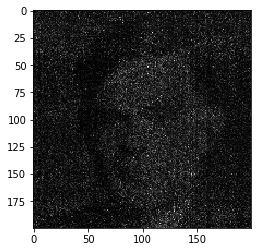

In [56]:
ss = np.sum(new_distribution)
print(ss)
plt.imshow(new_distribution, cmap='gray')

### Part 2. Model MADE.

In [67]:
class MaskLinear(torch.nn.Linear):
    def __init__(self, n, m, mask, bias=True):
        super().__init__(n, m, bias)        
        self.mask = mask.float()
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)

In [72]:
class MADEModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        size = 400
        rng = np.random.RandomState(566)
        m = [rng.permutation(size), rng.randint(0, size - 1, size=size)]
        
        mask1 = torch.tensor((m[0][:,None] <= m[1][None,:]).astype(float)).float()
        mask2 = torch.tensor((m[1][:,None] < m[0][None,:]).astype(float)).float()
        l1 = MaskLinear(size, size, mask1)
        l2 = MaskLinear(size, size, mask2)

        self.model = torch.nn.Sequential(
            l1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            l2,
        )
        self.softmax = torch.nn.Softmax(dim=2)
        
    def forward(self, x):
        x1, x2 = x[:,0], x[:,1]
        
        one_hot_1 = F.one_hot(x[:, 0], 200).float()
        one_hot_2 = F.one_hot(x[:, 1], 200).float()
        one_hot = torch.cat((one_hot_1, one_hot_2), dim=1)

        p = self.model(one_hot.float())
        p = p.view(-1, 2, 200)
        p = self.softmax(p)
        p = torch.gather(p, 2, torch.tensor(x.reshape(len(x), -1, 1))).view(len(x), 2)
        return p

In [100]:
model = MADEModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


global_step = 0
train_losses = {}
val_losses = {}
NUM_EPOCHS = 30

for epoch in range(NUM_EPOCHS):
    for idx, train_batch in enumerate(train_loader):
        optimizer.zero_grad()
        result = model(train_batch)
        loss = torch.mean(torch.log2(result + 1e-9) * -1)
        loss.backward()

        optimizer.step()

        train_losses[global_step] = loss.item()
        global_step += 1

        print('\rINFO: [Epoch %d/%d][idx %d/%d][Global Step: %d] Loss: %s'\
            % (epoch, NUM_EPOCHS, idx, len(train_loader), global_step, loss.item()), end="")

    model.eval()
    for idx, val_batch in enumerate(val_loader):
        result = model(val_batch)
        val_loss = torch.mean(torch.log2(result + 1e-9) * -1)
    model.train()    

    val_losses[global_step] = val_loss.item()

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: [Epoch 29/30][idx 68/69][Global Step: 2070] Loss: 2.2473251819610596

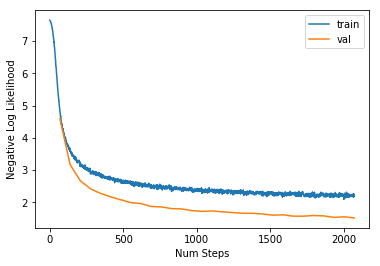

In [101]:
val_x_vals = val_losses.keys()
val_y_vals = val_losses.values()

# Plot the graphs
plt.xlabel('Num Steps')
plt.ylabel('Negative Log Likelihood')
train_x_vals = sorted(train_losses.keys())
train_y_vals = [train_losses[k] for k in train_x_vals]
val_x_vals = sorted(val_losses.keys())
val_y_vals = [val_losses[k] for k in val_x_vals]

plt.plot(train_x_vals, train_y_vals, label='train')
plt.plot(val_x_vals, val_y_vals, label='val')

plt.legend(loc='best')
plt.show()

In [102]:
arr = np.zeros(shape=(200*200, 2), dtype=int)
for i in range(200):
    for j in range(200):
        arr[i * 200 + j][0] = i
        arr[i * 200 + j][1] = j
        
new_distribution_2 = model(torch.from_numpy(arr))
new_distribution_2 = new_distribution_2.detach().numpy()
new_distribution_2 = np.array([x * y for x, y in new_distribution_2])

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


3269.6997


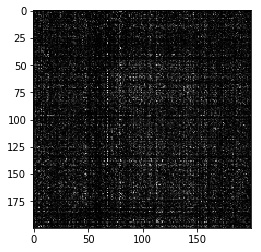

In [103]:
new_distribution_2 = new_distribution_2.reshape(200, 200)
ss = np.sum(new_distribution_2)
print(ss)
plt.imshow(new_distribution_2/ss, cmap='gray')

## Task 3. High dimensional data

As far as I understand, I will have to use a MADE architecture here. But it does not work yet from previous task, so I will just read the data for now and learn how to use it.

In [110]:
import pickle

with open('mnist-hw1.pkl', 'rb') as f:
    data = pickle.load(f)

In [112]:
len(data['train'])

60000

In [113]:
len(data['test'])

10000

In [115]:
len(data)

2